##Dowloading the dataset

In [1]:
 ! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp /content/kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets list -s rsna-bone

ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
kmader/rsna-bone-age                                        RSNA Bone Age                                         9GB  2018-01-24 14:37:16          18808        415  0.7058824        
vbookshelf/computed-tomography-ct-images                    Brain CT Images with Intracranial Hemorrhage Masks   90MB  2019-12-04 17:43:22           6413         80  0.7058824        
ipythonx/rsna-bone-age                                      RSNA Bone Age+Anatomical ROIS                        10GB  2020-08-29 17:30:09            167          6  0.6875           
abdallahgmarzouk/rsnaboneage-tfrecords                      RSNA-Bone-age TFReco

In [6]:
! kaggle datasets download kmader/rsna-bone-age

Dataset URL: https://www.kaggle.com/datasets/kmader/rsna-bone-age
License(s): other
100% 9.29G/9.29G [08:28<00:00, 18.8MB/s]
100% 9.29G/9.29G [08:28<00:00, 19.6MB/s]


In [7]:
! unzip /content/rsna-bone-age.zip

Streaming output truncated to the last 5000 lines.
  inflating: boneage-training-dataset/boneage-training-dataset/4264.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4265.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4266.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4268.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4269.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4270.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4271.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4272.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4273.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4275.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4276.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4277.png  
  inflating: boneage-training-dataset/boneage-training-datase

## import packages

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## data analysis


In [9]:
train_df = pd.read_csv('/content/boneage-training-dataset.csv')
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
boneage_mean = train_df['boneage'].mean()
boneage_std = train_df['boneage'].std()
train_df['boneage'] = (train_df['boneage'] - boneage_mean)/(boneage_std)

In [10]:
train_df.head()

,id,boneage,male
0,1377.png,1.279181,False
1,1378.png,-2.800269,False
2,1379.png,-0.809109,False
3,1380.png,-0.177766,True
4,1381.png,-1.100498,False


In [11]:
test_df = pd.read_csv('/content/boneage-test-dataset.csv')

In [12]:
test_df.head()

,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M
3,4363,M
4,4364,M


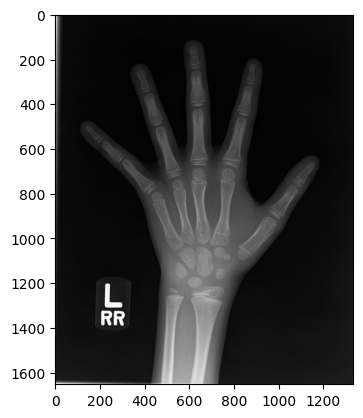

In [13]:
import cv2
img = cv2.imread("/content/boneage-training-dataset/boneage-training-dataset/10000.png")
plt.imshow(img)

Text(0.5, 1.0, 'Number of children in each age group')

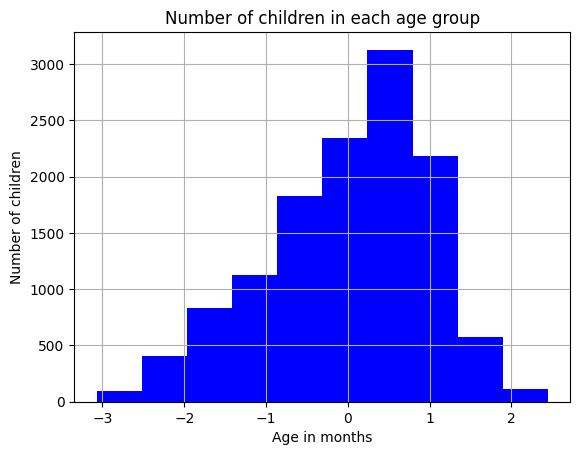

In [14]:
train_df['boneage'].hist(color = 'blue')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

## data preparation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.inception_v3 import preprocess_input

In [16]:
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)

## setting up wandb

In [17]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [25]:
import wandb

In [23]:
wandb.login()

wandb: Currently logged in as: reshma71995 (reshmaraj13). Use `wandb login --relogin` to force relogin


True

In [21]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [39]:
configs = dict(
    batch_size = 64,
    image_size = 256,
    lr = 0.001,
    epochs = 25,
    activation = "relu",
    seed = 42,
    dropout = 0.3,
    loss = "mse",
    steps_per_epoch = 75,

)

In [40]:
run = wandb.init(
    project = "boneage_prediction_project",
    config = configs
)

In [41]:
data_augmenation = dict(rotation_range=0.2, zoom_range=0.1, horizontal_flip=True,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                shear_range=0.05, fill_mode='nearest')
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input,  **data_augmenation)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [42]:
train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train,
    directory = "/content/boneage-training-dataset/boneage-training-dataset",
    x_col= 'id',
    y_col= 'boneage',
    batch_size = configs["batch_size"],
    seed = configs["seed"],
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (configs["image_size"], configs["image_size"]))

Found 10088 validated image filenames.


In [43]:
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = '/content/boneage-training-dataset/boneage-training-dataset',
    x_col = 'id',
    y_col = 'boneage',
    batch_size = configs["batch_size"],
    seed = configs["seed"],
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (configs["image_size"], configs["image_size"]))

Found 2523 validated image filenames.


In [44]:
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_data_generator.flow_from_directory(
    directory = '/content/boneage-test-dataset',
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (configs["image_size"],configs["image_size"]))

Found 200 images belonging to 1 classes.


In [45]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(configs["image_size"], configs["image_size"], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.trainable = True

# Create new model on top
inputs = tf.keras.Input(shape=(configs["image_size"], configs["image_size"], 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(configs["dropout"])(x)  # Regularize with dropout
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = configs["activation"])(x)
x = tf.keras.layers.Dense(64, activation = configs["activation"])(x)
x = tf.keras.layers.Dense(32, activation = configs["activation"])(x)
outputs = tf.keras.layers.Dense(1, activation = 'linear')(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 inception_v3 (Functional)   (None, 6, 6, 2048)        2180278   Y          
                                                       4                    
                                                                            
 global_average_pooling2d_1  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 2048)              0         Y          
                                                                            
 flatten_1 (Flatten)         (None, 2048)              0     

In [46]:
AdaMax = tf.keras.optimizers.Adamax(
    learning_rate=configs["lr"], beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [47]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    return mean_absolute_error((boneage_std*x_p + boneage_mean), (boneage_std*y_p + boneage_mean))

In [48]:
model.compile(
    optimizer= AdaMax,
    loss= configs["loss"],
    metrics = [mae_in_months])

In [49]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'inceptiov3_imsize256_model.h5',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
   )

In [51]:
reduce_lrplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=8,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0)

In [52]:
wandb_callbacks = [
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="inceptionv3_{epoch:02d}"),
]

In [53]:
callbacks = [early_stopping, model_checkpoint, reduce_lrplateau, wandb_callbacks]

In [54]:
history = model.fit(train_generator,
                            steps_per_epoch = configs["steps_per_epoch"],
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = configs["epochs"], callbacks= callbacks)

Epoch 1/25
75/75 [==============================] - ETA: 0s - loss: 0.4047 - mae_in_months: 20.1063

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (./inceptionv3_01)... Done. 0.9s


75/75 [==============================] - 285s 3s/step - loss: 0.4047 - mae_in_months: 20.1063 - val_loss: 0.5110 - val_mae_in_months: 23.3245 - lr: 0.0010
Epoch 2/25
75/75 [==============================] - ETA: 0s - loss: 0.1817 - mae_in_months: 13.9633

wandb: Adding directory to artifact (./inceptionv3_02)... Done. 0.9s


75/75 [==============================] - 245s 3s/step - loss: 0.1817 - mae_in_months: 13.9633 - val_loss: 0.5819 - val_mae_in_months: 26.7824 - lr: 0.0010
Epoch 3/25
75/75 [==============================] - ETA: 0s - loss: 0.1402 - mae_in_months: 12.2542

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (./inceptionv3_03)... Done. 2.0s


75/75 [==============================] - 242s 3s/step - loss: 0.1402 - mae_in_months: 12.2542 - val_loss: 0.1785 - val_mae_in_months: 13.4605 - lr: 0.0010
Epoch 4/25
75/75 [==============================] - ETA: 0s - loss: 0.1388 - mae_in_months: 12.1041

wandb: Adding directory to artifact (./inceptionv3_04)... Done. 0.9s


75/75 [==============================] - 238s 3s/step - loss: 0.1388 - mae_in_months: 12.1041 - val_loss: 0.1998 - val_mae_in_months: 15.7206 - lr: 0.0010
Epoch 5/25
75/75 [==============================] - ETA: 0s - loss: 0.1293 - mae_in_months: 11.7339

wandb: Adding directory to artifact (./inceptionv3_05)... Done. 0.9s


75/75 [==============================] - 240s 3s/step - loss: 0.1293 - mae_in_months: 11.7339 - val_loss: 0.2307 - val_mae_in_months: 15.3264 - lr: 0.0010
Epoch 6/25
75/75 [==============================] - ETA: 0s - loss: 0.1183 - mae_in_months: 11.2796

wandb: Adding directory to artifact (./inceptionv3_06)... Done. 0.9s


75/75 [==============================] - 241s 3s/step - loss: 0.1183 - mae_in_months: 11.2796 - val_loss: 0.2429 - val_mae_in_months: 16.4969 - lr: 0.0010
Epoch 7/25
75/75 [==============================] - ETA: 0s - loss: 0.1269 - mae_in_months: 11.6471

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (./inceptionv3_07)... Done. 0.9s


75/75 [==============================] - 241s 3s/step - loss: 0.1269 - mae_in_months: 11.6471 - val_loss: 0.1375 - val_mae_in_months: 12.3065 - lr: 0.0010
Epoch 8/25
75/75 [==============================] - ETA: 0s - loss: 0.1207 - mae_in_months: 11.3145

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (./inceptionv3_08)... Done. 0.9s


75/75 [==============================] - 237s 3s/step - loss: 0.1207 - mae_in_months: 11.3145 - val_loss: 0.1035 - val_mae_in_months: 9.9848 - lr: 0.0010
Epoch 9/25
75/75 [==============================] - ETA: 0s - loss: 0.1238 - mae_in_months: 11.3059

wandb: Adding directory to artifact (./inceptionv3_09)... Done. 0.9s


75/75 [==============================] - 241s 3s/step - loss: 0.1238 - mae_in_months: 11.3059 - val_loss: 0.1516 - val_mae_in_months: 13.1761 - lr: 0.0010
Epoch 10/25
75/75 [==============================] - ETA: 0s - loss: 0.1131 - mae_in_months: 11.0101

wandb: Adding directory to artifact (./inceptionv3_10)... Done. 0.8s


75/75 [==============================] - 243s 3s/step - loss: 0.1131 - mae_in_months: 11.0101 - val_loss: 0.1957 - val_mae_in_months: 15.3077 - lr: 0.0010
Epoch 11/25
75/75 [==============================] - ETA: 0s - loss: 0.1048 - mae_in_months: 10.5378

wandb: Adding directory to artifact (./inceptionv3_11)... Done. 0.8s


75/75 [==============================] - 244s 3s/step - loss: 0.1048 - mae_in_months: 10.5378 - val_loss: 0.1444 - val_mae_in_months: 12.5865 - lr: 0.0010
Epoch 12/25
75/75 [==============================] - ETA: 0s - loss: 0.1007 - mae_in_months: 10.2145

wandb: Adding directory to artifact (./inceptionv3_12)... Done. 0.9s


75/75 [==============================] - 244s 3s/step - loss: 0.1007 - mae_in_months: 10.2145 - val_loss: 0.1095 - val_mae_in_months: 11.2020 - lr: 0.0010
Epoch 13/25
75/75 [==============================] - ETA: 0s - loss: 0.1048 - mae_in_months: 10.6411

wandb: Adding directory to artifact (./inceptionv3_13)... Done. 0.9s


75/75 [==============================] - 243s 3s/step - loss: 0.1048 - mae_in_months: 10.6411 - val_loss: 0.1429 - val_mae_in_months: 12.2956 - lr: 0.0010
Epoch 14/25
75/75 [==============================] - ETA: 0s - loss: 0.0970 - mae_in_months: 10.1147

wandb: Adding directory to artifact (./inceptionv3_14)... Done. 1.0s


75/75 [==============================] - 243s 3s/step - loss: 0.0970 - mae_in_months: 10.1147 - val_loss: 0.1401 - val_mae_in_months: 12.6196 - lr: 0.0010
Epoch 15/25
75/75 [==============================] - ETA: 0s - loss: 0.0967 - mae_in_months: 10.1168

wandb: Adding directory to artifact (./inceptionv3_15)... Done. 1.0s


75/75 [==============================] - 244s 3s/step - loss: 0.0967 - mae_in_months: 10.1168 - val_loss: 0.1651 - val_mae_in_months: 13.5606 - lr: 0.0010
Epoch 16/25
75/75 [==============================] - ETA: 0s - loss: 0.0948 - mae_in_months: 9.9972

wandb: Adding directory to artifact (./inceptionv3_16)... Done. 1.0s


75/75 [==============================] - 244s 3s/step - loss: 0.0948 - mae_in_months: 9.9972 - val_loss: 0.1410 - val_mae_in_months: 11.8190 - lr: 0.0010
Epoch 17/25
75/75 [==============================] - ETA: 0s - loss: 0.0834 - mae_in_months: 9.3727

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (./inceptionv3_17)... Done. 1.0s


75/75 [==============================] - 248s 3s/step - loss: 0.0834 - mae_in_months: 9.3727 - val_loss: 0.0908 - val_mae_in_months: 9.7678 - lr: 1.0000e-04
Epoch 18/25
75/75 [==============================] - ETA: 0s - loss: 0.0768 - mae_in_months: 8.9301

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (./inceptionv3_18)... Done. 1.0s


75/75 [==============================] - 246s 3s/step - loss: 0.0768 - mae_in_months: 8.9301 - val_loss: 0.0613 - val_mae_in_months: 8.0931 - lr: 1.0000e-04
Epoch 19/25
75/75 [==============================] - ETA: 0s - loss: 0.0723 - mae_in_months: 8.6737

wandb: Adding directory to artifact (./inceptionv3_19)... Done. 1.0s


75/75 [==============================] - 245s 3s/step - loss: 0.0723 - mae_in_months: 8.6737 - val_loss: 0.0707 - val_mae_in_months: 8.5124 - lr: 1.0000e-04
Epoch 20/25
75/75 [==============================] - ETA: 0s - loss: 0.0730 - mae_in_months: 8.7733

wandb: Adding directory to artifact (./inceptionv3_20)... Done. 0.9s


75/75 [==============================] - 243s 3s/step - loss: 0.0730 - mae_in_months: 8.7733 - val_loss: 0.1211 - val_mae_in_months: 11.4944 - lr: 1.0000e-04
Epoch 21/25
75/75 [==============================] - ETA: 0s - loss: 0.0669 - mae_in_months: 8.4422

wandb: Adding directory to artifact (./inceptionv3_21)... Done. 0.8s


75/75 [==============================] - 241s 3s/step - loss: 0.0669 - mae_in_months: 8.4422 - val_loss: 0.1039 - val_mae_in_months: 10.2218 - lr: 1.0000e-04
Epoch 22/25
75/75 [==============================] - ETA: 0s - loss: 0.0678 - mae_in_months: 8.4035

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (./inceptionv3_22)... Done. 1.0s


75/75 [==============================] - 243s 3s/step - loss: 0.0678 - mae_in_months: 8.4035 - val_loss: 0.0524 - val_mae_in_months: 7.4316 - lr: 1.0000e-04
Epoch 23/25
75/75 [==============================] - ETA: 0s - loss: 0.0684 - mae_in_months: 8.4227

wandb: Adding directory to artifact (./inceptionv3_23)... Done. 1.0s


75/75 [==============================] - 241s 3s/step - loss: 0.0684 - mae_in_months: 8.4227 - val_loss: 0.0950 - val_mae_in_months: 9.9924 - lr: 1.0000e-04
Epoch 24/25
75/75 [==============================] - ETA: 0s - loss: 0.0709 - mae_in_months: 8.6933

wandb: Adding directory to artifact (./inceptionv3_24)... Done. 1.0s


75/75 [==============================] - 241s 3s/step - loss: 0.0709 - mae_in_months: 8.6933 - val_loss: 0.1033 - val_mae_in_months: 10.6455 - lr: 1.0000e-04
Epoch 25/25
75/75 [==============================] - ETA: 0s - loss: 0.0692 - mae_in_months: 8.4532

wandb: Adding directory to artifact (./inceptionv3_25)... Done. 1.0s


75/75 [==============================] - 241s 3s/step - loss: 0.0692 - mae_in_months: 8.4532 - val_loss: 0.0762 - val_mae_in_months: 9.5087 - lr: 1.0000e-04


In [72]:
def plotlosscurve(history):
    '''function to plot training and validation loss'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    plt.title('loss curve')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [73]:
def ploterrorcurve(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Error curve')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

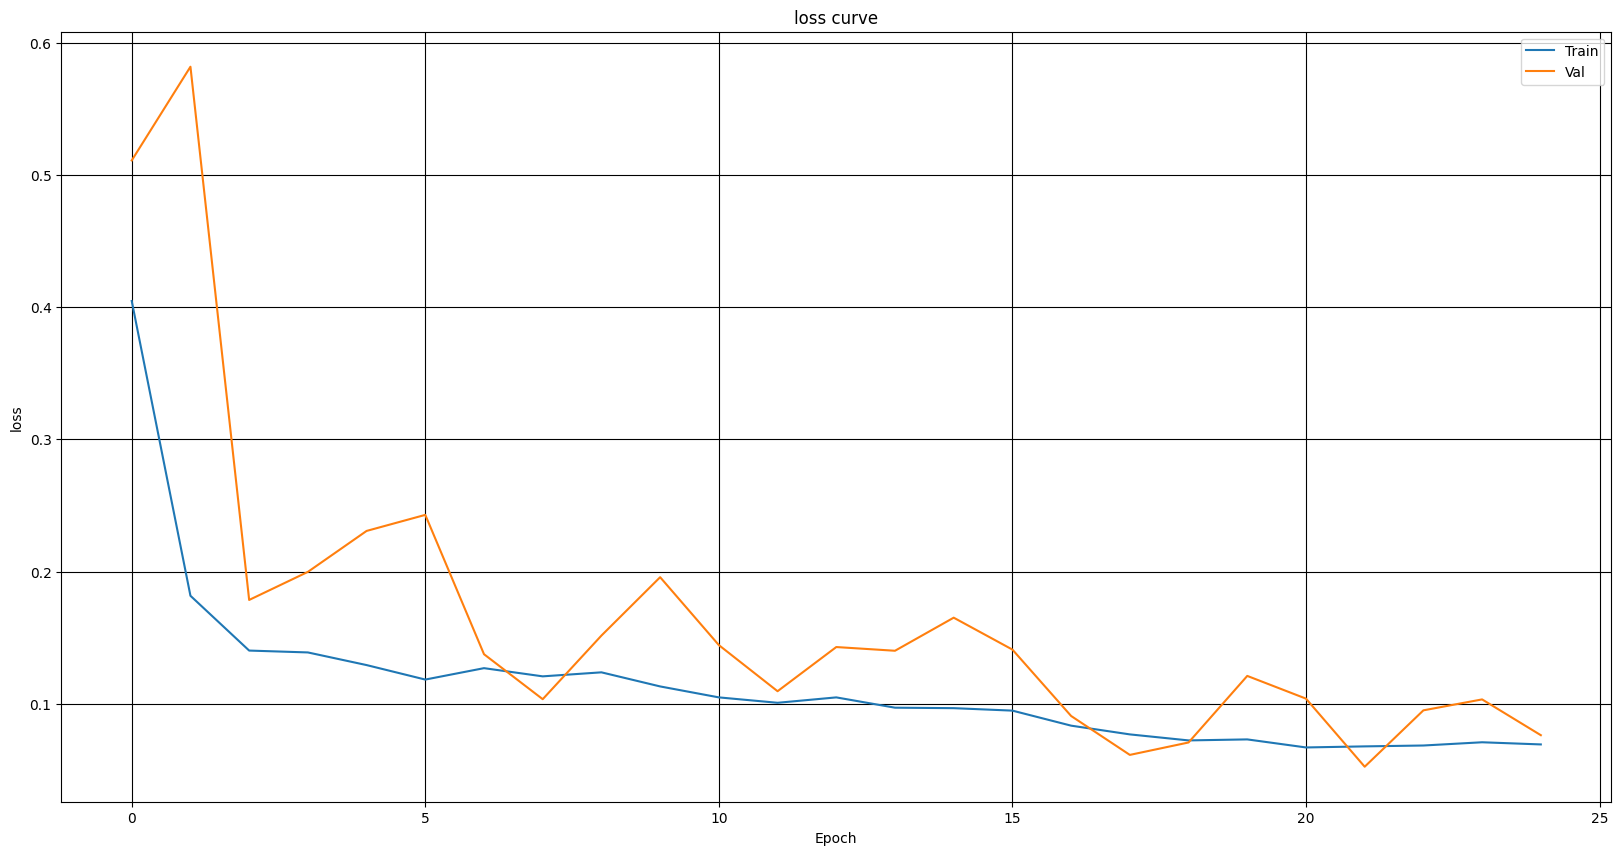

In [70]:
plotlosscurve(history)

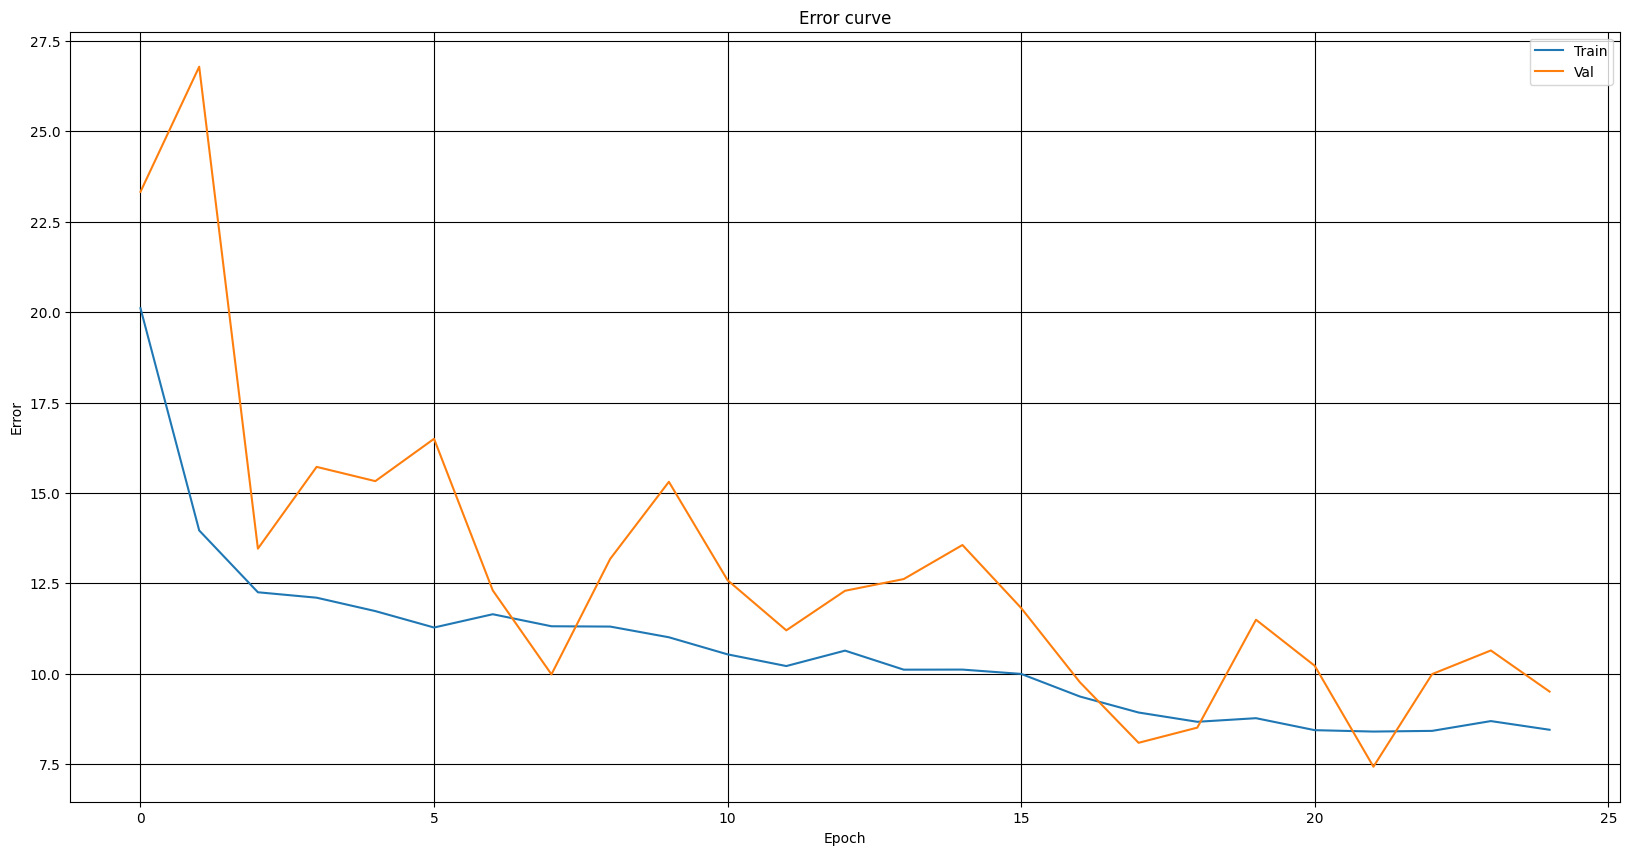

In [74]:
ploterrorcurve(history)

In [66]:
predictions = model.predict(test_generator)
predictions_1 = predictions.reshape(-1)
y_months = boneage_std*predictions_1 + boneage_mean
filenames = test_generator.filenames
results=pd.DataFrame({"file":filenames,"prediction":y_months})
results.to_csv("boneage_testdata_prediction.csv")

7/7 [==============================] - 5s 641ms/step
